In [22]:
import sys
sys.path.append("..")

In [23]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xgboost
from satreeverify.xgb_utils import *

In [24]:
data = load_breast_cancer()
X = data['data']
y = data["target"]
feature_names = data["feature_names"]
y = y==1

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
ntrees = 50
clf = xgboost.XGBClassifier(n_estimators=ntrees, max_depth=3).fit(x_train, y_train)
clf.score(x_test, y_test)

[23:58:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/masoud/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9736842105263158

In [27]:
dump = clf.get_booster().get_dump(dump_format="json")
all_thresh = get_ens_thresh(dump)
data_ = disc_data(x_train[:2,:], all_thresh)
print(data_.shape)
data_.head()

(2, 126)


,21_28.5450001,23_784.150024,19_0.00353299989,23_739.199951,24_0.135800004,3_696.25,14_0.00331400009,4_0.0887549967,22_105.949997,26_0.21450001,...,23_810.800049,21_29.1399994,18_0.0168749988,23_736.400024,21_19.5050011,4_0.0899100006,24_0.1373,13_43.0800018,6_0.0624250025,4_0.088135004
0,True,False,True,False,False,False,True,True,False,True,...,False,True,False,False,True,True,False,False,True,True
1,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,True,True,False,False,False,True


In [28]:
var_x = {f"x({i})": Bool(f"x({i})") for i in data_.columns}

# Soft Attack

In [29]:
epsilon = 0.34
index = 12

sample = X[index:index+1, :]
clf.predict_proba(sample)

array([[0.99804944, 0.00195057]], dtype=float32)

In [30]:
s, c_weights = soft_attack(clf, sample, epsilon, var_x)

False
sat


In [31]:
adv_weights = get_output(s, c_weights)
1 / (1 + np.exp(-np.sum([v for k, v in adv_weights.items()])))

0.7874833210122415

In [32]:
clf.predict_proba(sample)[0][1]

0.0019505733

In [33]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.78748333

In [34]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
1,24.800000,16.374160,0.339752,"[15.5349998, 16.375]"
21,29.940000,20.044460,0.330512,"[19.5050011, 20.0450001]"
22,151.700000,105.844047,0.302281,"[-inf, 105.949997]"
27,0.176700,0.123587,0.300581,"[0.111000001, 0.123600006]"
23,1332.000000,957.360762,0.281261,"[868.199951, 957.450012]"
25,0.390300,0.311260,0.202510,"[0.171750009, 0.311399996]"
20,20.960000,16.773211,0.199751,"[-inf, 16.7900009]"
28,0.317600,0.280568,0.116601,"[0.198249996, 0.28065002]"
4,0.097400,0.088755,0.088761,"[0.0884599984, 0.0887549967]"
0,19.170000,19.170000,0.000000,"[-inf, inf]"


# Hard Attack

## weight distribution

In [35]:
w = np.asarray([v for k,v in c_weights.items()])
w.min(), w.max()

(-0.581250012, 0.572413802)

(array([ 2.,  4., 19., 28., 67., 62., 27., 20.,  4.,  1.]),
 array([-0.58125001, -0.46588363, -0.35051725, -0.23515087, -0.11978449,
        -0.0044181 ,  0.11094828,  0.22631466,  0.34168104,  0.45704742,
         0.5724138 ]),
 <BarContainer object of 10 artists>)

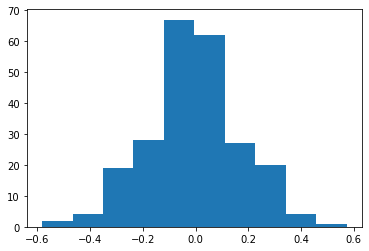

In [36]:
plt.hist(w)

## Attacking sample

In [37]:
epsilon = 0.34
index = 12

nbits = 8
sample = X[index:index+1, :]

In [38]:
s, c_weights, seq_nump, seq_numn = hard_attack(clf, sample, epsilon, var_x, nbits)

False
sat


In [39]:
clf.predict_proba(sample)[0][1]

0.0019505733

In [40]:
adv_weights = get_output(s, c_weights)
val = np.sum([v for k, v in adv_weights.items()])
1 / (1 + np.exp(-val))

0.51306205456736

In [41]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.51306206

In [42]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
21,29.940000,20.224819,0.324488,"[20.0450001, 20.2249985]"
22,151.700000,105.844047,0.302281,"[-inf, 105.949997]"
23,1332.000000,957.360762,0.281261,"[868.199951, 957.450012]"
27,0.176700,0.135799,0.231470,"[0.135049999, 0.135800004]"
1,24.800000,19.761609,0.203161,"[16.375, 19.7649994]"
20,20.960000,16.799989,0.198474,"[16.7900009, 16.7999992]"
25,0.390300,0.325596,0.165780,"[0.171750009, 0.325749993]"
28,0.317600,0.280717,0.116129,"[0.198249996, 0.280799985]"
4,0.097400,0.088047,0.096028,"[-inf, 0.088135004]"
0,19.170000,19.170000,0.000000,"[-inf, inf]"
